# Regression & Results

The analysis is split between 3 notebooks.:
1) data_collection.ipynb (this notebook): which downloads data from Google Earth Engine (can be slow)
2) data_processing.ipynb: which merges the data into dataframe that is ready to use for regression
3) regression.ipynb: which performs the regression and prediction of the Aboveground Biomass and calculates the carbon stored

In this notebook, we:
* Load the data from part 2
* Add more features to the data (NDVI and Co)
* Use XGBoost to train a model to predict AGBD
* Apply Model to whole map
* Calculate Carbon Stored in the forest 

## Imports

In [30]:
import geopandas as gpd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np

import pandas as pd
import numpy as np
import math
import warnings


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, ParameterGrid,
)
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, DMatrix, plot_importance
from xgboost import cv as xgb_cv

# Load data

In [ ]:
# Load the data
df = gpd.read_file('data/train_data.json')

In [4]:
# Check all the columns
df.columns

Index(['agbd', 'agbd_se', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',
       'B8', 'B8A', 'B9', 'DEM', 'Map', 'slope', 'VH', 'VV', 'geometry'],
      dtype='object')

In [6]:
# We are not using spatial information for the modelling
if 'geometry' in df.columns:
    df = df.drop(columns='geometry')
# Also, we can drop the agbd_se column. We won't use the uncertainty anymore
if 'agbd_se' in df.columns:
    df = df.drop(columns='agbd_se')    

## Feature Engineering

There are a lot of vegetation indices that can be calculated from the sentinel 2 data. 

Here I have a large selection of features. We will filter for the most useful ones afterwards.

In [7]:
eps = 1e-10  # small value to avoid division by zero

# NDVI
df['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4'] + eps)

# GNDVI (Green NDVI)
df['GNDVI'] = (df['B8'] - df['B3']) / (df['B8'] + df['B3'] + eps)

# DVI (Difference Vegetation Index)
df['DVI'] = df['B8'] - df['B4']

# EVI (Enhanced Vegetation Index)
df['EVI'] = 2.5 * (df['B8'] - df['B4']) / (df['B8'] + 6 * df['B4'] - 7.5 * df['B2'] + 1 + eps)

# MCARI (Modified Chlorophyll Absorption Ratio Index)
df['MCARI'] = ((df['B5'] - df['B4']) - 0.2 * (df['B5'] - df['B3'])) * (df['B5'] / (df['B4'] + eps))

# S2REP (Red Edge Position, Sentinel-2)
df['S2REP'] = 705 + 35 * (((df['B5'] + df['B7']) / 2 - df['B4']) / (df['B6'] - df['B4'] + eps))

# REIP (Red Edge Inflection Point)
df['REIP'] = df['S2REP']  # often approximated as S2REP

# CCCI (Canopy Chlorophyll Content Index)
df['CCCI'] = ((df['B8'] - df['B4']) / (df['B8'] + df['B4'] + eps)) * ((df['B8'] - df['B5']) / (df['B8'] + df['B5'] + eps))

# CIRE (Chlorophyll Index Red Edge)
df['CIRE'] = (df['B8'] / (df['B5'] + eps)) - 1

# CVI (Chlorophyll Vegetation Index)
df['CVI'] = (df['B8'] / df['B4'] + eps) * (df['B8'] / df['B2'] + eps)

# GLI (Green Leaf Index)
df['GLI'] = (2 * df['B3'] - df['B4'] - df['B2']) / (2 * df['B3'] + df['B4'] + df['B2'] + eps)

# GRNDVI (Green-Red NDVI)
df['GRNDVI'] = (df['B3'] - df['B4']) / (df['B3'] + df['B4'] + eps)

# BWDRVI (Blue Wide Dynamic Range VI)
df['BWDRVI'] = (0.1 * df['B8'] - df['B4']) / (0.1 * df['B8'] + df['B4'] + eps)

# NDVIRE (Red-edge NDVI)
df['NDVIRE'] = (df['B8A'] - df['B5']) / (df['B8A'] + df['B5'] + eps)

# WDVI (Weighted Difference Vegetation Index)
soil_slope = 0.2
df['WDVI'] = df['B8'] - soil_slope * df['B4']

# --- Tasseled Cap Transform (Baig et al., 2014) ---
# Brightness (TCB)
df['TCB'] = (0.3037 * df['B2'] + 0.2793 * df['B3'] + 0.4743 * df['B4'] +
                0.5585 * df['B8'] + 0.5082 * df['B11'] + 0.1863 * df['B12'])

# Greenness (TCG)
df['TCG'] = (-0.2848 * df['B2'] - 0.2435 * df['B3'] - 0.5436 * df['B4'] +
                0.7243 * df['B8'] + 0.0840 * df['B11'] - 0.1800 * df['B12'])

# Wetness (TCW)
df['TCW'] = (0.1509 * df['B2'] + 0.1973 * df['B3'] + 0.3279 * df['B4'] +
                0.3406 * df['B8'] - 0.7112 * df['B11'] - 0.4572 * df['B12'])

# Tasseled Cap Distance (TCD)
df['TCD'] = np.sqrt(df['TCB']**2 + df['TCG']**2 + df['TCW']**2)

In [8]:
df.columns

Index(['agbd', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
       'B9', 'DEM', 'Map', 'slope', 'VH', 'VV', 'NDVI', 'GNDVI', 'DVI', 'EVI',
       'MCARI', 'S2REP', 'REIP', 'CCCI', 'CIRE', 'CVI', 'GLI', 'GRNDVI',
       'BWDRVI', 'NDVIRE', 'WDVI', 'TCB', 'TCG', 'TCW', 'TCD'],
      dtype='object')

## Feature Selection

We now have a lot of features. To avoid overfitting and avoid troubles from correlation between features, we select the most useful features.

We are keeping the features that have low correlation between each other and at the same time have a strong correlation with our target 'agbd'.

In [9]:
import pandas as pd
import numpy as np

# 1. Remove non-numeric and geometry columns (if GeoDataFrame)
df_numeric = df.select_dtypes(include='number')

# 2. Separate predictors and target
target = 'agbd'
predictors = df_numeric.drop(columns=[target])

# 3. Calculate Pearson correlation of predictors with 'agbd'
target_corr = df_numeric.corr()[target].drop(target).abs()
target_corr_sorted = target_corr.sort_values(ascending=False)

# 4. Compute pairwise correlation matrix of predictors
corr_matrix = predictors.corr().abs()

# 5. Initialize list of selected features
selected_features = []
correlation_threshold = 0.9  # max allowed correlation between features

# 6. Greedy selection based on agbd correlation and low inter-correlation
for feature in target_corr_sorted.index:
    is_correlated = False
    for sel in selected_features:
        if corr_matrix.loc[feature, sel] > correlation_threshold:
            is_correlated = True
            break
    if not is_correlated:
        selected_features.append(feature)

print("Selected features with low collinearity and high AGBD correlation:")
print(selected_features)


Selected features with low collinearity and high AGBD correlation:
['CVI', 'Map', 'B3', 'B2', 'VH', 'GRNDVI', 'DEM', 'GNDVI', 'TCB', 'VV', 'B12', 'B11', 'TCG', 'TCW', 'B6', 'EVI', 'B9', 'S2REP', 'slope']


## Regression

* We have a lot of data, so we can do some testing how well the prediction works.
* We split the data first into test and training data. The training data is further split into training and validation data.
* We use the training data to tune the model and make validate it on the validation data to make sure that we are not overfitting.
* A final check performed on the test data that is not involved in the training at all

In [10]:
# Let's start by splitting the data into train, validation and test sets
train_df, test_df = train_test_split(df, test_size=0.1, shuffle=True)
# Let's use the first 80% of the data for training and the last 20% for validation
train_df, val_df = train_test_split(train_df, test_size=0.1, shuffle=True)

# Define the features and target variable
features = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12',
       'VV', 'VH', 'DEM', 'slope', 'Map', 'NDVI', 'GNDVI', 'DVI',
       'EVI', 'MCARI', 'S2REP', 'REIP', 'CCCI', 'CIRE', 'CVI', 'GLI', 'GRNDVI',
       'BWDRVI', 'NDVIRE', 'WDVI', 'TCB', 'TCG', 'TCW', 'TCD']

#features = ['NDVI', 'B4', 'B12', 'TCD','Map']
#features=[ 'B12', 'B2', 'CCCI', 'CVI', 'CIRE', 'GLI', 'GNDVI', 'MCARI', 'NDVIRE', 'TCD', 'Map']
#features = ['Map', 'B4', 'DEM', 'B11', 'GNDVI', "EVI", 'B8','TCD']
features = selected_features

target_col = "agbd"

X_train = train_df[features][:1000]
y_train = train_df[target_col][:1000]
X_val = val_df[features]
y_val = val_df[target_col]
X_test = test_df[features]
y_test = test_df[target_col]



In [11]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np

# 1. Combine training and validation into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test)

# 2. Set parameters — you can tune these
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 2,
    'subsample': 0.3,
    'colsample_bytree': 0.3,
    'seed': 42
}

# 3. Train with early stopping on validation set
evals = [(dtrain, 'train'), (dval, 'val')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=50  # print every 50 rounds
)
# 4. Predict on test set
y_pred_test = model.predict(dtest)
# 5. Evaluate performance
mae = mean_absolute_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)
per_err = np.mean(np.abs(y_test-y_pred_test)/y_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {r2:.3f}")
print(f"Test perr_err: {per_err*100:.3f}")


[0]	train-rmse:86.43363	val-rmse:84.10573


[50]	train-rmse:49.62859	val-rmse:51.42793
[100]	train-rmse:45.77694	val-rmse:51.27942
[114]	train-rmse:45.04575	val-rmse:51.16116
Test MAE: 26.246
Test RMSE: 52.853
Test R2: 0.658
Test perr_err: 38.546


The data turned out to be quite noisy and with a high error. There is a base uncertainty of 7 Mg/ha on all measurements, so all low abgd measurements are removed due to high uncertainty. But this is the best that can be done.

The hyperparameters of XGBoost are chosen to have shallow regression trees because there is a lot of noise and deeper trees would lead to overfitting.

Text(0, 0.5, 'predicted')

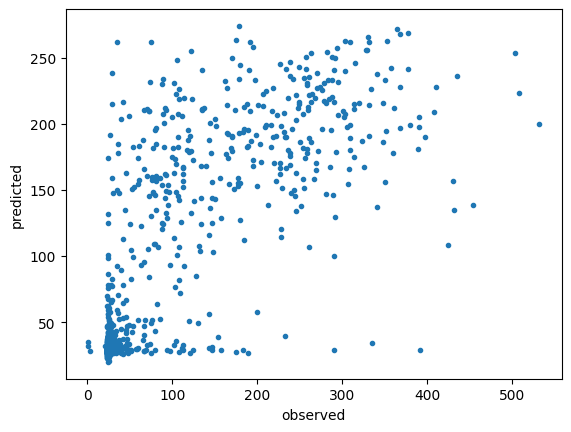

In [12]:
# Let's have a look at how the predictions are looking
plt.plot(y_test,y_pred_test,'.')
plt.xlabel('observed')
plt.ylabel('predicted')

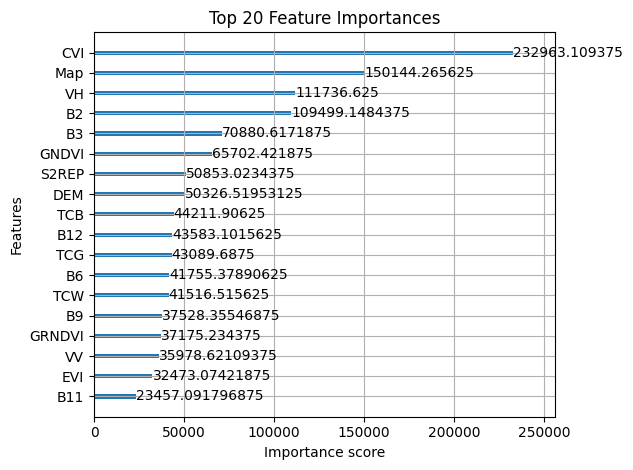

In [13]:
# Plot feature importance
xgb.plot_importance(model, max_num_features=30, importance_type='gain')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


The Land Cover (Map) helps a lot with the regression because it is a strong indicator of how much vegetation/biomass is around. Overall the CVI (Chlorophyll Vegetation Index) was the most important feature. Also the VH channel from SAR/Sentinel 1 was an useful addition. This might look different for different areas of interest.

## Predict model

In [24]:
# Load Data
df = gpd.read_file('data/full_data.json')

In [26]:
# We need to calculate all the features again


eps = 1e-10  # small value to avoid division by zero

# NDVI
df['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4'] + eps)

# GNDVI (Green NDVI)
df['GNDVI'] = (df['B8'] - df['B3']) / (df['B8'] + df['B3'] + eps)

# DVI (Difference Vegetation Index)
df['DVI'] = df['B8'] - df['B4']

# EVI (Enhanced Vegetation Index)
df['EVI'] = 2.5 * (df['B8'] - df['B4']) / (df['B8'] + 6 * df['B4'] - 7.5 * df['B2'] + 1 + eps)

# MCARI (Modified Chlorophyll Absorption Ratio Index)
df['MCARI'] = ((df['B5'] - df['B4']) - 0.2 * (df['B5'] - df['B3'])) * (df['B5'] / (df['B4'] + eps))

# S2REP (Red Edge Position, Sentinel-2)
df['S2REP'] = 705 + 35 * (((df['B5'] + df['B7']) / 2 - df['B4']) / (df['B6'] - df['B4'] + eps))

# REIP (Red Edge Inflection Point)
df['REIP'] = df['S2REP']  # often approximated as S2REP

# CCCI (Canopy Chlorophyll Content Index)
df['CCCI'] = ((df['B8'] - df['B4']) / (df['B8'] + df['B4'] + eps)) * ((df['B8'] - df['B5']) / (df['B8'] + df['B5'] + eps))

# CIRE (Chlorophyll Index Red Edge)
df['CIRE'] = (df['B8'] / (df['B5'] + eps)) - 1

# CVI (Chlorophyll Vegetation Index)
df['CVI'] = (df['B8'] / df['B4'] + eps) * (df['B8'] / df['B2'] + eps)

# GLI (Green Leaf Index)
df['GLI'] = (2 * df['B3'] - df['B4'] - df['B2']) / (2 * df['B3'] + df['B4'] + df['B2'] + eps)

# GRNDVI (Green-Red NDVI)
df['GRNDVI'] = (df['B3'] - df['B4']) / (df['B3'] + df['B4'] + eps)

# BWDRVI (Blue Wide Dynamic Range VI)
df['BWDRVI'] = (0.1 * df['B8'] - df['B4']) / (0.1 * df['B8'] + df['B4'] + eps)

# NDVIRE (Red-edge NDVI)
df['NDVIRE'] = (df['B8A'] - df['B5']) / (df['B8A'] + df['B5'] + eps)

# WDVI (Weighted Difference Vegetation Index)
soil_slope = 0.2
df['WDVI'] = df['B8'] - soil_slope * df['B4']

# --- Tasseled Cap Transform (Baig et al., 2014) ---
# Brightness (TCB)
df['TCB'] = (0.3037 * df['B2'] + 0.2793 * df['B3'] + 0.4743 * df['B4'] +
                0.5585 * df['B8'] + 0.5082 * df['B11'] + 0.1863 * df['B12'])

# Greenness (TCG)
df['TCG'] = (-0.2848 * df['B2'] - 0.2435 * df['B3'] - 0.5436 * df['B4'] +
                0.7243 * df['B8'] + 0.0840 * df['B11'] - 0.1800 * df['B12'])

# Wetness (TCW)
df['TCW'] = (0.1509 * df['B2'] + 0.1973 * df['B3'] + 0.3279 * df['B4'] +
                0.3406 * df['B8'] - 0.7112 * df['B11'] - 0.4572 * df['B12'])

# Tasseled Cap Distance (TCD)
df['TCD'] = np.sqrt(df['TCB']**2 + df['TCG']**2 + df['TCW']**2)

In [27]:
# We only need the selected features for the predictions

# Prepare the dataframe for XGBoost (turn into DMatrix)
d_pred  = xgb.DMatrix(df[selected_features])
# Run the prediction
agbd_pred = model.predict(d_pred)
# Add the prediction ot the dataframe
df['agbd'] = agbd_pred

In [21]:
#  We only need these 3 columns inthe following
df =df[['geometry', 'agbd', 'Map']]

# Let's save the results to a file
df.to_file('predicted_agbd.json', driver='GeoJSON')

## Visualisation

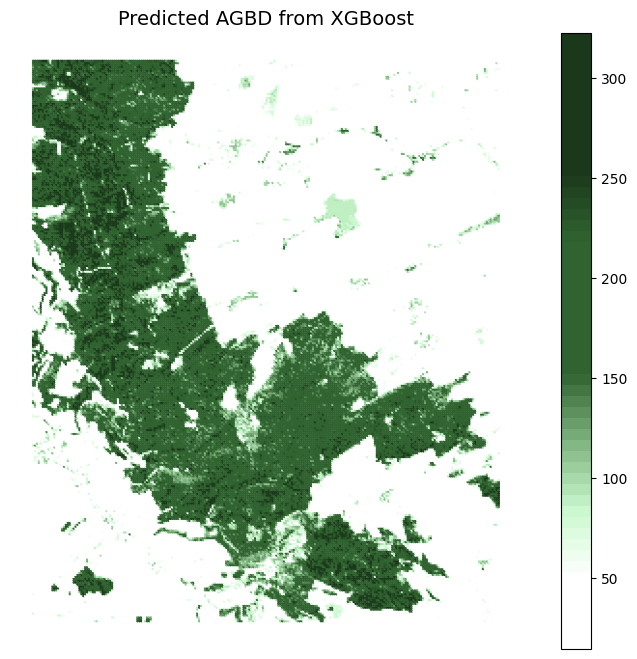

In [ ]:
# Define a custom colormap (There is probably a better way to do it, but this works)
green_colormap = LinearSegmentedColormap.from_list(
    'white_to_darkgreen',
    ['white', "#FFFFFF", "#C9F8CD", "#7FB37F", "#306330", "#306330", "#306330", "#1A381A", "#1A381A", "#1A381A"],  # white → light green → dark green
    N=56
)

# Set figure size and plot
fig, ax = plt.subplots(figsize=(10, 8))

df.plot(
    column='agbd',
    cmap=green_colormap,       # Choose your preferred colormap
    legend=True,
    ax=ax,
    markersize=1,         # Adjust depending on your data scale
    alpha=1
)

# Optional enhancements
ax.set_title('Predicted AGBD from XGBoost', fontsize=14)
ax.set_axis_off()
plt.show()


## Calculate Total ABG

First, we are filtering out the landcover types that do not contain biomass. Also biomass on cropland should not be considered

10  Tree cover
20	Shrubland
30	Grassland
40	Cropland
50	Built-up
60	Bare / sparse vegetation
70	Snow and ice
80	Permanent water bodies
90	Herbaceous wetland
95	Mangroves
100	Moss and lichen

In [33]:
# For the aboveground biomass estimation, we want to keep relevant landcover types
# 10, 20, 30, 90, 95

df_agb = df.copy()
df_agb = df_agb[df_agb['Map'].isin([10, 20, 30, 90, 95])]

In [34]:
# let's do a check what the average density looks like it should be around 100ish
print(df_agb['agbd'].mean())

134.84357


In [35]:
# Calculating the total biomass is quite straightforward
# The density values are given in Mg/ha
# 1 Pixel is 100m x 100m = 1ha
# Each pixel represent 1ha, so the total AGB is equal to the density

total_agb = df_agb['agbd'].sum()

print(f"Total Aboveground Biomass (AGB): {total_agb:,.2f} tonnes")


# A rough estimation of how much carbon is stored in the Biomass is 50% of the mass is carbon
total_carbon = total_agb * 0.5
print(f"Estimated Carbon Stock: {total_carbon:,.2f} tonnes C")
print(f"Estimated Carbon Stock: {total_carbon/1e3:,.2f} kilo tonnes C")
print(f"Estimated Carbon Stock: {total_carbon/1e6:,.2f} Mega tonnes C")
print(f"Estimated Carbon Stock: {total_carbon/1e9:,.2f} Giga tonnes C")


Total Aboveground Biomass (AGB): 5,778,991.00 tonnes
Estimated Carbon Stock: 2,889,495.50 tonnes C
Estimated Carbon Stock: 2,889.50 kilo tonnes C
Estimated Carbon Stock: 2.89 Mega tonnes C
Estimated Carbon Stock: 0.00 Giga tonnes C


# Final Thoughts

Congrats you made it to the end. Now you know how to estimate biomass from space. All that is required is LiDAR data on the aboveground biomass and combine it with additional data.

I think the main part to improve the forecast would be get better biomass data. ESA's biomass satellite will add great open access data to our data base. Local measurements of biomass could lead to better results. I was expecting the results to be much better than a 30-40% accuracy. Maybe a different forest would be better.